# LIDAR point cloud registration with quaternions

Following [Wang et al. (2014)], (http://dx.doi.org/10.1016/j.isprsjprs.2014.04.013), [Yan-Bin Jia (2022)](https://faculty.sites.iastate.edu/jia/files/inline-files/quaternion.pdf) and [Shen et al. (2006)](https://link.springer.com/article/10.1007/s00190-006-0054-8) we register LIDAR data found in Wang et al. (2014) with quaternions.

Unregistered stations are $p_i$, reference stations are $q_i$.

<div>
<img src="figs/Jia_fig_3_en.png" width="600"/>
</div>


Steps of the algorithm

1. Calculation of coordinates relative to the centroid
2. Calculation of the $M$ matrix 
3. Calculation of the eigenvalues and eigenvectors of the $M$ matrix. The maximum eigenvalue associated with the eigenvector of the $M$ matrix is the solution of the rotation quaternion $q$
4. Calculation of the rotation matrix
5. Calculation of the $k$ scale parameter
6. Calculation of the shift parameter $t$

Among the operations related to quaternions, it is necessary to calculate the rotation matrix. For this, we use the simple [`squaternion`](https://github.com/MomsFriendlyRobotCompany/squaternion) library written by Kevin Walchko.

Read and plot [data](lidar.dat):
    
<div>
<img src="figs/lidar.png" width="600"/>
</div>


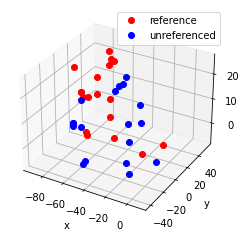

In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as LA
from squaternion import Quaternion
import matplotlib.pyplot as plt

# LIDAR data
dat = np.loadtxt('lidar.dat')

ref = dat[:,1:4]
unr = dat[:,4:]
npts = len(ref[:,0])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(ref[:,0], ref[:,1], ref[:,2], "ro", label="reference")
ax.plot(unr[:,0], unr[:,1], unr[:,2], "bo", label="unreferenced")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(loc="upper right")


Calculation of the $M$ matrix

In [2]:
# remove mean
pm = np.mean(unr,axis=0)
qm = np.mean(ref,axis=0)
pv = unr-pm
qv = ref-qm

def quat2Q(q):
    Q = np.zeros((4,4))
    Q[1:,0] = np.array(q.vector)
    Q[2,1] =  q.z
    Q[3,1] = -q.y
    Q[3,2] =  q.x
    Q = Q - np.tril(Q).T
    return Q

def quat2P(p):
    P = np.zeros((4,4))
    P[1:,0] = np.array(p.vector)
    P[2,1] = -p.z
    P[3,1] =  p.y
    P[3,2] = -p.x
    P = P - np.tril(P).T
    return P

def v2q(v):
    q = Quaternion(0,v[0],v[1],v[2])
    return q

# Calculate matrix M
M = np.zeros((4,4))
for i in range(npts):
    pi = v2q(pv[i])
    qi = v2q(qv[i])
    Pi = quat2P(pi)
    Qi = quat2Q(qi)
    Mi = np.dot(Pi.T,Qi)
    M = M + Mi

We determine the eigenvector corresponding to the largest eigenvalue of the matrix $M$, which is the rotation quaternion required for the fit.

In [3]:
w,v = LA.eig(M)

# eigenvector corresponding to the largest eigenvalue
i = np.argmax(w)
vmx = v[:,i]
qr = Quaternion(vmx[0],vmx[1],vmx[2],vmx[3])
print("rotation quaternion: ", qr)
# rotation matrix
r = np.array( qr.to_rot() )
print("rotation matrix: ")
for i in range(3):
    print("{:12.9f} {:12.9f} {:12.9f}".format(r[i,0],r[i,1],r[i,2]))

rotation quaternion:  Quaternion(w=-0.9611777758345228, x=0.03668139078696401, y=-0.10309160306701529, z=-0.2533059023963061)
rotation matrix: 
 0.850416482 -0.494507094  0.179595490
 0.479380921  0.868981191  0.122742098
-0.216761941 -0.018287252  0.976053194


Results found in the paper [Wang et al. (2014)](http://dx.doi.org/10.1016/j.isprsjprs.2014.04.013):
<div>
<img src="figs/results.png" width="900"/>
</div>

Now let's calculate the scale factor $k$ and the offset $t$.

In [4]:
# scale factor 
kn = 0
kd = 0
for i in range(npts):
    kni = np.dot(np.dot(qv[i,:],r),pv[i,:])
    kdi = np.dot(pv[i,:],pv[i,:])
    kn += kni
    kd += kdi
k = kn/kd
print("scale factor: {:.9f}".format(k))

# offset
t = qm - k*np.dot(r,pm)
print("offset: ")
print("{:8.4f} {:8.4f} {:8.4f}".format(t[0],t[1],t[2]))

scale factor: 1.000385442
offset: 
-22.9656  29.3962  -2.2652


Let's transform the points and see if they fit.

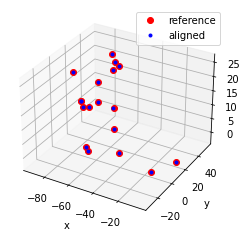

In [5]:
# transformation
trf = k*np.dot(r,unr.T).T + t

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(ref[:,0], ref[:,1], ref[:,2], "ro", label="reference")
ax.plot(trf[:,0], trf[:,1], trf[:,2], "bo", ms=3, label="aligned")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(loc="upper right")

Let's calculate and plot residual distances at each station!

Text(0, 0.5, 'residual (m)')

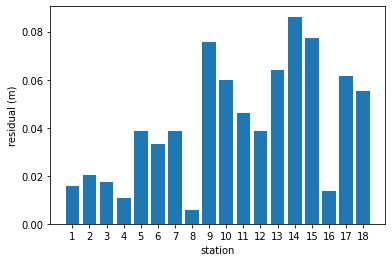

In [6]:
# residuals
dr = trf-ref
dv = LA.norm(dr,axis=1)
pt = list(range(1,npts+1))
fig = plt.figure()
plt.bar(pt,dv)
plt.xticks(pt)
plt.xlabel('station')
plt.ylabel('residual (m)')